## Data Preparation

Mempersiapkan dan memastikan bahwa data yang digunakan untuk analisis adalah data yang berkualitas dan dapat digunakan untuk modelling

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

df = pd.read_csv('train.csv', sep = ';')
df.sample(5)

FileNotFoundError: [Errno 2] No such file or directory: 'train.csv'

In [135]:
cats = df.select_dtypes(include = ['object']).columns
nums = df.select_dtypes(include = ['int64', 'float64']).columns

cats, nums

(Index(['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact',
        'month', 'poutcome', 'y'],
       dtype='object'),
 Index(['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous'], dtype='object'))

### Missing Values

In [136]:
df.isna().sum()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64

Tidak perlu handling missing values, dikarenakan tidak ada kolom yang null

### Duplicate Values

In [137]:
df.duplicated().any()

False

Tidak perlu handling duplicated values di karenakan tidak ada value duplikat

### Penanganan Outliers 

Kami mempertimbangkan untuk  penanganan outliers menggunakan Z-score untuk menentukan seberapa jauh suatu data berada dari rata-rata, dengan Z-score tinggi dianggap sebagai outlier atau nilai ekstrem , kami mempertimbangkan dengan memilih z-score dikarenakan kami tidak ingin kehilangan banyak data. Dikarenakan data nya tidak berdistribusi normal maka kami melakukan log transformasi terlebih dahulu.

In [138]:
for i in nums:
    if (df[i] < 0).any():
        df[i] = df.apply(lambda x : int(0) if int(x[i]) < 0 else x[i], axis = 1)
    print(f"Total negative value of {i}:", (df[i] < 0).sum())

Total negative value of age: 0
Total negative value of balance: 0
Total negative value of day: 0
Total negative value of duration: 0
Total negative value of campaign: 0
Total negative value of pdays: 0
Total negative value of previous: 0


Sebelum melakukan log transformasi, dicek terlebih dahulu agar tidak ada negatif values ketika log transformasi

In [139]:
for i in nums:
    if i not in ['age', 'day']:
        df[i] = np.log(df[i] + (df[df[i] > 0][i].min() / 2))

In [140]:
df.describe()

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,5.199427,15.806419,5.167016,0.963267,0.389388,-0.373537
std,10.618762,3.007085,8.322476,0.927908,0.590519,2.311494,0.727591
min,18.000000,-0.693147,1.000000,-0.693147,0.405465,-0.693147,-0.693147
25%,33.000000,4.283587,8.000000,4.639572,0.405465,-0.693147,-0.693147
50%,39.000000,6.105909,16.000000,5.195731,0.916291,-0.693147,-0.693147
75%,48.000000,7.264380,21.000000,5.766757,1.252763,-0.693147,-0.693147
max,95.000000,11.533977,31.000000,8.500759,4.151040,6.770216,5.618588


Terlihat dari `df.describe()` bahwa data sudah berdistribusi normal

In [141]:
from scipy import stats

print("Before removing outlier: ", len(df))

for i in nums:
    if i not in ['age', 'day']:
        z_scores = np.abs(stats.zscore(df[i]))
        df = df[z_scores <= 3]

print("After removing outlier: ", len(df))

Before removing outlier:  45211
After removing outlier:  43173


Setelah removing outlier dengan zscore terdapat 2.038 data yang di remove

### Normalization Transformation

Seebelum dilakukan scalling dengan normalization, data perlu di split terlebih dahulu, menjadi train dan test

In [142]:
X = df.drop(columns=['y'])
y = df[['y']]

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [143]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
for i in list(X_train.select_dtypes(include = ['int64', 'float64']).columns):
    fitted = scaler.fit(X_train[[i]])
    X_train[i] = fitted.transform(X_train[[i]])
    X_test[i] = fitted.transform(X_test[[i]])

In [144]:
train = pd.concat([X_train, y_train], axis = 1)
test = pd.concat([X_test, y_test], axis = 1)

train = train[train['education'] != 'unknown']
test = test[test['education'] != 'unknown']

X_train = train.drop(columns=['y'])
y_train = train[['y']]

X_test = test.drop(columns=['y'])
y_test = test[['y']]

### Lable Encoding & One Hot Encoding

Fitur-fitur kategorikal perlu di-encode menjadi representasi numerik agar dapat digunakan dalam model. dengan label encoding pada kolom `education`, `default`, `housing`, `loan` dan `month`. untuk kolom month di jadikan 4 kuartal menjadi 'month quarter'
dan one hot encoding untuk kolom `job` dan `month quarter`

In [145]:
#drop marital and contact columns
X_train.drop(['marital'], axis=1, inplace=True)
X_test.drop(['marital'], axis=1, inplace=True)
X_train.drop(['contact'], axis=1, inplace=True)
X_test.drop(['contact'], axis=1, inplace=True)


In [146]:
X_train['education_mapped'] = X_train['education'].map({'primary' : 0,
                                                        'secondary' : 1,
                                                        'tertiary' : 2})

X_test['education_mapped'] = X_test['education'].map({'primary' : 0,
                                                      'secondary' : 1,
                                                      'tertiary' : 2})

X_train['is_default'] = X_train['default'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_default'] = X_test['default'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_housing'] = X_train['housing'].map({'no' : 0,
                                                'yes' : 1})

X_test['is_housing'] = X_test['housing'].map({'no' : 0,
                                              'yes' : 1})

X_train['is_loan'] = X_train['loan'].map({'no' : 0,
                                          'yes' : 1})

X_test['is_loan'] = X_test['loan'].map({'no' : 0,
                                        'yes' : 1})

X_train['month_quarter'] = X_train['month'].apply(lambda x : 'first' if x in ['jan', 'feb', 'mar'] else 'second'\
                                                                     if x in ['apr', 'may', 'jun'] else 'third'\
                                                                     if x in ['jul', 'aug', 'sep'] else 'fourth')

X_test['month_quarter'] = X_test['month'].apply(lambda x : 'first' if x in ['jan', 'feb', 'mar'] else 'second'\
                                                                   if x in ['apr', 'may', 'jun'] else 'third'\
                                                                   if x in ['jul', 'aug', 'sep'] else 'fourth')

X_train['is_poutcome_succcess'] = X_train['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

X_test['is_poutcome_succcess'] = X_test['poutcome'].apply(lambda x : 1 if x == 'success' else 0)

y_train['y'] = y_train['y'].map({'no' : 0,
                                 'yes' : 1})

y_test['y'] = y_test['y'].map({'no' : 0,
                               'yes' : 1})

In [147]:
for i in ['job', 'month_quarter']:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[i], prefix = i)], axis = 1)
    X_test = pd.concat([X_test, pd.get_dummies(X_test[i], prefix = i)], axis = 1)

In [148]:
X_train = X_train.drop(columns = list(X_train.select_dtypes(include = ['object']).columns) + ['job_unknown'] )
X_test = X_test.drop(columns = list(X_test.select_dtypes(include = ['object']).columns) + ['job_unknown'])

In [149]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 28968 entries, 25386 to 3566
Data columns (total 27 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   age                   28968 non-null  float64
 1   balance               28968 non-null  float64
 2   day                   28968 non-null  float64
 3   duration              28968 non-null  float64
 4   campaign              28968 non-null  float64
 5   pdays                 28968 non-null  float64
 6   previous              28968 non-null  float64
 7   education_mapped      28968 non-null  int64  
 8   is_default            28968 non-null  int64  
 9   is_housing            28968 non-null  int64  
 10  is_loan               28968 non-null  int64  
 11  is_poutcome_succcess  28968 non-null  int64  
 12  job_admin.            28968 non-null  uint8  
 13  job_blue-collar       28968 non-null  uint8  
 14  job_entrepreneur      28968 non-null  uint8  
 15  job_housemaid   

### Class Imbalance

In [150]:
from imblearn import over_sampling

X_train_over, y_train_over = over_sampling.SMOTE(random_state = 14).fit_resample(X_train, y_train)

In [151]:
len(X_train_over), len(y_train_over), len(X_train), len(y_train), len(X_test), len(y_test)

(51230, 51230, 28968, 28968, 12433, 12433)

In [152]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier



def eval_classification():
    
    list_model = {'Logistic Regression' : LogisticRegression(random_state = 14),
                  'KNN Classifier' : KNeighborsClassifier(),
                  'Decision Tree Classifier' : DecisionTreeClassifier(random_state = 14),
                  'Random Forest Classifier' : RandomForestClassifier(random_state = 14)}
                  
    
    for key, val in list_model.items():
        model = val
        model.fit(X_train_over, y_train_over)
    
        y_pred = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        y_pred_proba = model.predict_proba(X_test)
        y_pred_proba_train = model.predict_proba(X_train)

        print(key, "Evaluation Result")
        print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
        print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
        print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
        print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
        print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
        print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
        print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
        print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))
        print("")

In [153]:
eval_classification()

Logistic Regression Evaluation Result
Accuracy (Train Set): 0.81
Accuracy (Test Set): 0.81
Precision (Train Set): 0.35
Precision (Test Set): 0.35
Recall (Train Set): 0.81
Recall (Test Set): 0.82
F1-Score (Train Set): 0.49
F1-Score (Test Set): 0.49

KNN Classifier Evaluation Result
Accuracy (Train Set): 0.88
Accuracy (Test Set): 0.80
Precision (Train Set): 0.48
Precision (Test Set): 0.31
Recall (Train Set): 0.97
Recall (Test Set): 0.64
F1-Score (Train Set): 0.64
F1-Score (Test Set): 0.41

Decision Tree Classifier Evaluation Result
Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.84
Precision (Train Set): 1.00
Precision (Test Set): 0.36
Recall (Train Set): 1.00
Recall (Test Set): 0.55
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.43

Random Forest Classifier Evaluation Result
Accuracy (Train Set): 1.00
Accuracy (Test Set): 0.88
Precision (Train Set): 1.00
Precision (Test Set): 0.48
Recall (Train Set): 1.00
Recall (Test Set): 0.65
F1-Score (Train Set): 1.00
F1-Score (Test Set): 0.55


In [154]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ['l1', 'l2'],
          "C":[0.001,0.01,0.1,1,10,100]}

model = GridSearchCV(LogisticRegression(random_state = 14), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Logistic Regression")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'C': 0.1, 'penalty': 'l2'}
Best Score: 0.85

Tuned Logistic Regression
Accuracy (Train Set): 0.80
Accuracy (Test Set): 0.81
Precision (Train Set): 0.35
Precision (Test Set): 0.35
Recall (Train Set): 0.81
Recall (Test Set): 0.82
F1-Score (Train Set): 0.49
F1-Score (Test Set): 0.49


In [155]:
from sklearn.model_selection import GridSearchCV

params = {"penalty": ['l1', 'l2'],
          "C": [0.001, 0.01, 0.1, 1, 10, 100]}

best_params = {'C': 0.1, 'penalty': 'l2'}

params["C"] = [best_params["C"]]  
params["penalty"] = [best_params["penalty"]]

model = GridSearchCV(LogisticRegression(random_state = 14), 
                   param_grid = params, 
                   cv = 10, 
                   scoring = 'recall')

model.fit(X_train_over, y_train_over)
y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)
y_pred_proba = model.predict_proba(X_test)
y_pred_proba_train = model.predict_proba(X_train)

print(f'Best Parameter: {model.best_params_}')
print("Best Score: %.2f" % model.best_score_)
print('')

print("Tuned Logistic Regression")
print("Accuracy (Train Set): %.2f" % accuracy_score(y_train, y_pred_train))
print("Accuracy (Test Set): %.2f" % accuracy_score(y_test, y_pred))
print("Precision (Train Set): %.2f" % precision_score(y_train, y_pred_train))
print("Precision (Test Set): %.2f" % precision_score(y_test, y_pred))
print("Recall (Train Set): %.2f" % recall_score(y_train, y_pred_train))
print("Recall (Test Set): %.2f" % recall_score(y_test, y_pred))
print("F1-Score (Train Set): %.2f" % f1_score(y_train, y_pred_train))
print("F1-Score (Test Set): %.2f" % f1_score(y_test, y_pred))

Best Parameter: {'C': 0.1, 'penalty': 'l2'}
Best Score: 0.85

Tuned Logistic Regression
Accuracy (Train Set): 0.80
Accuracy (Test Set): 0.81
Precision (Train Set): 0.35
Precision (Test Set): 0.35
Recall (Train Set): 0.81
Recall (Test Set): 0.82
F1-Score (Train Set): 0.49
F1-Score (Test Set): 0.49


Text(1.9722222222222232, 0.5, 'Actual')

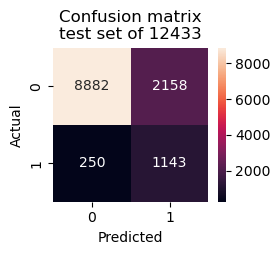

In [156]:
from sklearn.metrics import confusion_matrix

fig = plt.figure(figsize = (2.5,2))
sns.heatmap((confusion_matrix(y_test, y_pred)), annot = True, fmt = '.0f', ax = fig.add_subplot(1,1, 1))
plt.title(f'Confusion matrix\ntest set of {len(y_test)}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
